# API In-Class Assignment
---
Jan. 14, 2026 <br>
## Team: Clouds

# Dependencies

In [21]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import matplotlib.dates as mdates

# Data Access

In [2]:
# Define API URL
url = "https://waterdata.usgs.gov/nwis/uv?cb_all_=on&cb_00060=on&cb_00065=on&format=gif_stats&site_no=12451000&legacy=1&period=&begin_date=2025-12-11&end_date=2025-12-12"

# Download data
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

# localFile = 'pbdbDiversity.csv'

# # Save the response to a local file
# with open(localFile, "w", encoding="utf-8") as f:
#     f.write(response.text)

In [18]:
##Sofia's try at URL

url = 'https://waterservices.usgs.gov/nwis/iv/?format=rdb&sites=12451000&parameterCd=00060&startDT=2025-12-01&endDT=2025-12-31'

# Download data
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

# Split into lines and filter out comments
lines = response.text.split('\n')
data_lines = [line for line in lines if not line.startswith('#')]

# The first line is headers, second line is data types (skip it), rest is data
header = data_lines[0]
data = '\n'.join([header] + data_lines[2:])  # Skip the format descriptor row

# Read into DataFrame
stream_data = pd.read_csv(
    StringIO(data),
    sep="\t",
    parse_dates=["datetime"]
)

# Streamflow column has weird name, this code finds it based on API
# Find the streamflow column (parameter code 00060, without _cd suffix)
streamflow_col = [col for col in stream_data.columns if '00060' in col and not col.endswith('_cd')][0]

print(f"Streamflow column: {streamflow_col}")
print(f"Units: cubic feet per second (cfs)")

# Rename for clarity
stream_data = stream_data.rename(columns={streamflow_col: 'discharge_cfs'})

# Removing weird and unnecesary column
stream_data = stream_data.drop(columns=['151779_00060_cd'])

stream_data.head()

Streamflow column: 151779_00060
Units: cubic feet per second (cfs)


,agency_cd,site_no,datetime,tz_cd,discharge_cfs
0,USGS,12451000,2025-12-01 00:00:00,PST,732
1,USGS,12451000,2025-12-01 00:15:00,PST,732
2,USGS,12451000,2025-12-01 00:30:00,PST,716
3,USGS,12451000,2025-12-01 00:45:00,PST,724
4,USGS,12451000,2025-12-01 01:00:00,PST,708


In [16]:
##Sofia: Using JSON format to get metadata

# Use JSON format to get metadata
url_json = 'https://waterservices.usgs.gov/nwis/iv/?format=json&sites=12451000&parameterCd=00060&startDT=2025-12-01&endDT=2025-12-31'

response = requests.get(url_json)
data = response.json()

# Extract units from the metadata
time_series = data['value']['timeSeries'][0]
variable = time_series['variable']

print(f"Parameter: {variable['variableName']}")
print(f"Description: {variable['variableDescription']}")
print(f"Unit: {variable['unit']['unitCode']}")

Parameter: Streamflow, ft&#179;/s
Description: Discharge, cubic feet per second
Unit: ft3/s


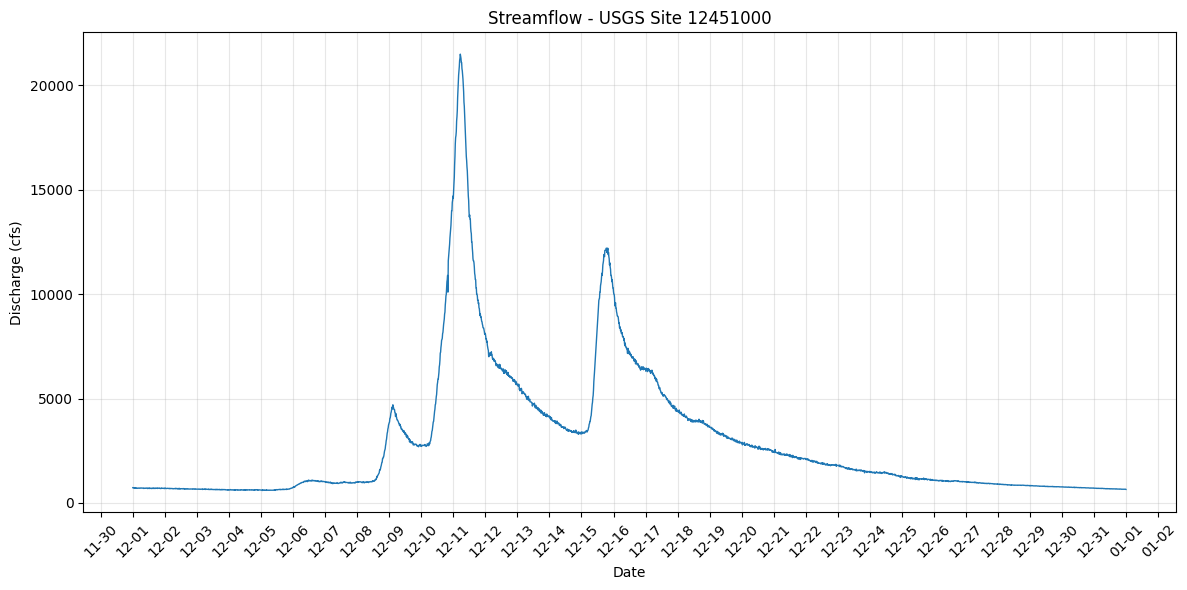

In [22]:
# Sofia: Making plot for streamgauge data

plt.figure(figsize=(12, 6))
plt.plot(stream_data['datetime'], stream_data['discharge_cfs'], linewidth=1)

plt.xlabel('Date')
plt.ylabel('Discharge (cfs)')
plt.title('Streamflow - USGS Site 12451000')

# Set major gridlines to daily
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()